In [1]:
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
mpl.rcParams['figure.figsize'] = (9,6)

stealing from https://rpubs.com/divjan/bsts

### Create Variables...

Z = state vector
z = mean and regression coefficents for state vector (mean of local level)

This corresponds to the _observation_ equation $y_t = Z_t^Tz_t + \epsilon$ 

In evernote you have this written as $y_t = H_t^Ty_{t_m} + \epsilon$ 

In [2]:

# length of the series
N = 500
pre = int(np.ceil(2*N/3)) #beginning of the treatment
postperiod = N-pre
# parameters of the state
statedim = 3
T = np.eye(statedim) #parameter matrix of state (A)
Q = 0.01*np.eye(statedim) #variance of state
x1 = np.sin(2*np.pi*np.arange(1,N+1)/90) # state vector 1 (0-indexed)
x2 = np.sin(2*np.pi*np.arange(1,N+1)/360) # state vector 2
# simulation of the state
z0 = np.array([5,0,0]) #initial conditions: mu_0=5, beta_1=0, beta_2=0
z = np.zeros((N,statedim))

# z is our States/process variable (X)
z[0] = z0.dot(T) + stats.norm.rvs(loc=np.zeros((statedim)), scale=np.diag(Q))
# I think this is our state update equation (for generating a true state)
#+ A_tX_{t-1} + B_tu_t + w_t
#+ Here we either ommit the control variables (or assume they are part of our state???)
#+ w_t is random normal with std = Q
for i in range(1,N):
    # z is just a random walk? since T does not actually transform (identity matrix)
    z[i] = z[i-1].dot(T) + stats.norm.rvs(loc=np.zeros((statedim)), scale=np.diag(Q))
    
# Z is our Observation Transform Matrix (H)
# eg Y=H_tX_t + v_t --> Y=Zz_t + v_t
# assuming H_t is consistent through time
sigmasq = 0.01 
Z = np.zeros((N,statedim)) 
Z[:,0] = np.repeat(1,N)
Z[:,1] = x1
Z[:,2] = x2
Z

e = 0.1 #effect size
y = np.zeros(N)
for i in range(N):
    y[i] = Z[i,].dot(z[i,]) + np.sqrt(sigmasq)*np.random.randn(1)

ye = np.copy(y)
ye[pre:N] = y[pre:N]*(1+e)

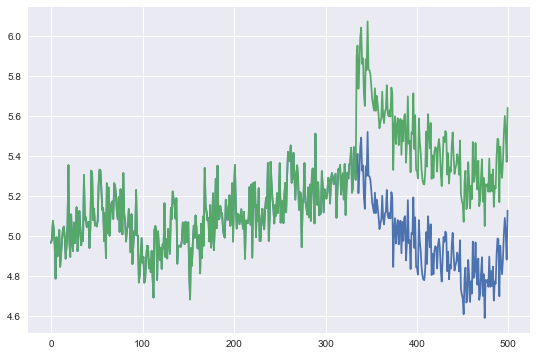

In [3]:
plt.plot(y)
plt.plot(ye)

## Kalman Filter Function

### _Equations_

_State Estimate Update_

$ \hat X_t = F_t X_{t-1} + B_tu_t + w_t $

_Process Cov Matrix Update_

$ P_t = F_tP_{t-1}F_t^T + Q_t $

_Measurement Update_

$ Y_t = HX_t + e_t $

_Kalman Gain_

$ K = \frac{P_tH^T}{HP_tH^T + R} $

In [64]:
def kf(y, F, H, R, Q, x0, P0, B=None, u=None):
    """
    y = Observed values
    F = State Transform matrix (assumed static)
    H = Process-Measurement Transform Matrix (Kalman Gain Transform Matrix)
    R = Variance of the Measurement?
    Q = Process Covariance Noise
    x0 = initial state vector
    P0 = initial Process Cov matrix
    
    B,U = Control Matrix and variables... regressors (u) and their coefficients (B)
        # B is assumed static (for now)
    """
    N = len(y)
    ndim = len(x0)
    
    # Controls/Covarates
    if isinstance(u, (np.ndarray, list, tuple)):
        assert B, 'Must pass control transform matrix (B) if passing control variables'
        assert len(u)  == len(y), "controls must be same length as observed"
        u = np.asarray(u)
    else:
        B,u = 0, np.zeros_like(y)
    
    # Set initial P0 to previous P0
    P_prev = P0
    
    #
    x_prev = np.zeros((N+1, ndim))
    x_curr = x_prev[1:]
    x_prev[0] = x0
    
    # start KF recursions
    for i in range(N):
        # make predictions
        # x` = Fx_{t-1} + Bu_{t-1} + w
        x_prev[i] = np.dot(F,x_prev[i]) + np.dot(B,u[i])
        P_prev = np.dot(np.dot(F,P_prev),F.T) + Q
        
        
        # Calculate Observation Error (S_t)
        total_err = np.dot(H[i], P_prev).dot(H[i].T) + R
        # Calculate Prediction Error (V_t)
        epsilon = y[i] - np.dot(H[i],x_prev[i])
        # kalman gain
        kg = P_prev.dot(H[i].T).dot(np.linalg.inv(total_err))
        # update x prev and x current
        #+ X_t = X_t` + K_tV_t
        if not np.isnan(epsilon):
            x_curr[i] = x_prev[i] + np.dot(kg, epsilon)
        else:
            x_curr[i] = x_prev[i]
        x_prev[i+1] = x_curr[i]
        # update P
        # reshapes are because numpy vector dot products reshape the _2nd_ vector to a column vector (we need the 1st as col vector)
        # P_t= (I - K_tH_t)P_t`
        # P_t= P_t` - K_tH_tP_t`
        # P_t` = A_{t-1}P_prevA_t^T + Q
        P_prev = P_prev - kg.reshape(-1,1).dot(H[i].reshape(1,-1)).dot(P_prev)
        
        
    return x_curr, P_prev

In [65]:
P0 = 10000*np.eye(statedim)
x0 = np.repeat(0,statedim)

X, P  = kf(y[:pre],F=T,H=Z[:pre].reshape(pre,1,-1),R=np.array([[sigmasq]]), Q=Q, x0=x0, P0=P0)

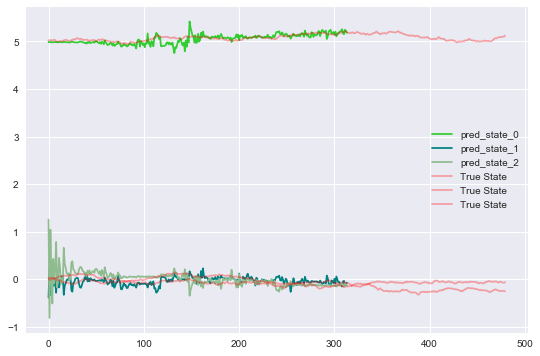

In [66]:
colors = ['limegreen','teal', 'darkseagreen']
for i in range(X.shape[1]):
    plt.plot(X[20:,i], color = colors[i], label = 'pred_state_{}'.format(i))

plt.plot(z[20:], color = 'red', alpha=0.33, label='True State')
plt.legend()

### Single Dimension Version

Using only local trend...

In [67]:
print('T:')
print(T)
print()
print('Q:')
print(Q)
print()

T:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Q:
[[0.01 0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.01]]



In [71]:
T=np.array([1])
Q=np.array([[0.1]]) # Controls amount of smoothing. Lower = more smoothe ()
R=np.array([[0.1]]) # sigmasq # Controls amount of smoothing. Higher = more smoothe ()
P0 = np.array([1000])
x0=np.array([y[0]])

H = Z[:pre,0].reshape(pre,1,-1)

X, P = kf(y[:pre], F=T, H=H, R=R, Q=Q, x0=x0, P0=P0)

array([[0.0618034]])

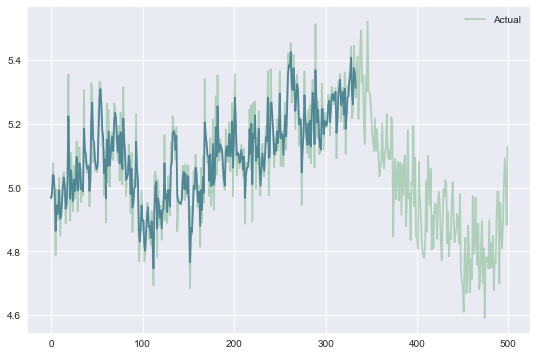

In [72]:
plt.plot(X)
plt.plot(y, alpha = 0.4, label = 'Actual')
plt.legend()
P

Add an Autoregressive Component

In [73]:
xx = np.roll(y,1)[1:]
yx = y[1:]
slope, intr = stats.linregress(xx,yx)[0],stats.linregress(xx,yx)[1]
slope, intr

(0.690766626908471, 1.564236582441183)

In [74]:
np.corrcoef(xx,yx)

array([[1.        , 0.69083694],
       [0.69083694, 1.        ]])

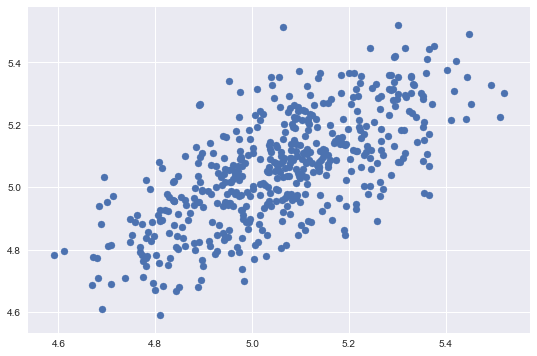

In [75]:
plt.scatter(xx,yx)

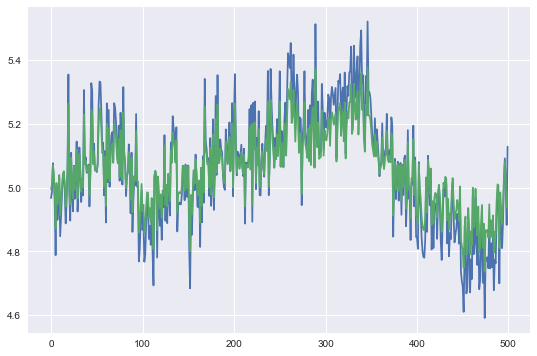

In [76]:
plt.plot(y)
plt.plot(slope*xx + intr)

In [79]:
F = np.array([slope])
B = np.array([intr])
u = np.ones_like(y[:pre])

Q=np.array([[0.5]]) # Prior for Error in the Estimate. Lower = More smoothe (aka more confidence in esitmate)
R=np.array([[0.51]]) # sigmasq # Prior for error in measurement. Higher = more smoothe (aka less confidence in measurment)
P0 = np.array([1000])
x0=np.array([y[0]])

H=Z[:pre,0].reshape(pre,1,-1)


X, P = kf(y[:pre], F=F, H=H, R=R, Q=Q, x0=x0, P0=P0, B=B, u=u)

array([[0.28282939]])

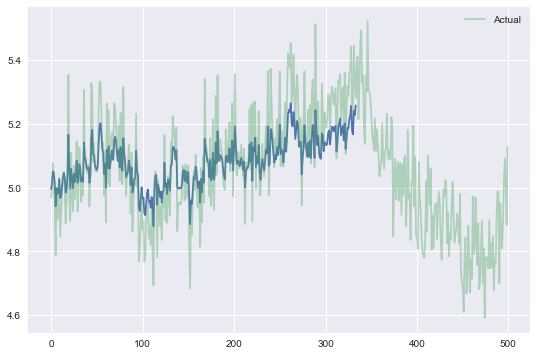

In [80]:
plt.plot(X)
plt.plot(y, alpha = 0.4, label = 'Actual')
plt.legend()
P

Introduce NaNs

In [81]:
na_idxs = np.random.randint(100, 200, 10)
y[na_idxs] = np.nan

X, P = kf(y[:pre], F=F, H=Z[:pre,0], R=R, Q=Q, x0=x0, P0=P0, B=B, u=u)

array([[0.28282939]])

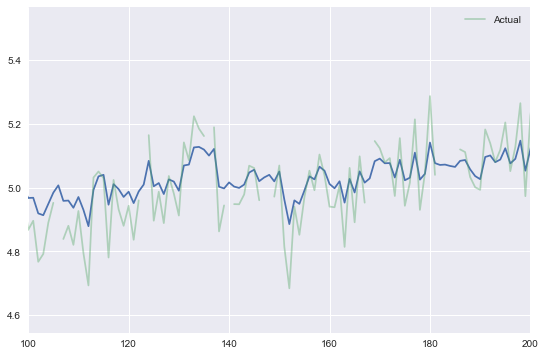

In [82]:
plt.plot(X)
plt.plot(y, alpha = 0.4, label = 'Actual')
plt.legend()
plt.xlim(100,200)
P

In [83]:
na_idxs

array([123, 185, 136, 184, 182, 168, 106, 148, 147, 140])